# Climatology Threshold

Given a daily dataset $D$, the mean climatology of that dataset $C_D$ and a threshold value $T_D$ for each day of the year, calculate the severity index

$$ S = {{D - C_D}\over{T_D - C_D}} $$

We need to match up each day in $D$ with the corresponding day in $C_D$ and $T_D$, and perform a two step operation on it.

In [1]:
import xarray
import climtas
import climtas.nci
import intake

climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:43941 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 4.29 GB


As a starting point, I'll look at a single year's data, with ERA5 daily tmax as the source dataset.

In [2]:
chunks = {'latitude':300, 'longitude': 300}

cat = intake.cat.nci.era5.search(dataset='single-levels', product_type='reanalysis', parameter='mx2t', year=2010).to_dataset_dict(cdf_kwargs={'chunks': chunks})
tmax = cat['era5.single-levels.reanalysis'].mx2t


--> The keys in the returned dictionary of datasets are constructed as follows:
	'sub_collection.dataset.product_type'


First let's check our initial chunking, before we do anything:

In [3]:
tmax

<xarray.DataArray 'mx2t' (time: 8760, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(8760, 721, 1440), dtype=float32, chunksize=(744, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
Attributes:
    units:      K
    long_name:  Maximum temperature at 2 metres since previous post-processing

Our chunk size here is ~ 250 mb, which is on the high side but reasonable. For a single year there are 372 tasks, about 2 tasks per chunk.

Our ERA5 archive holds the hourly data. We can calculate the daily tmax from the hourly tmax with a resample. `climtas.blocked_resample()` minimises the number of new chunks, but it does need the time axis to be regularly spaced

In [4]:
tmax_d = climtas.blocked_resample(tmax, time=24).max()

From the daily data we can then calculate the mean climatology and threshold

In [5]:
tmax_clim = climtas.blocked_groupby(tmax_d, time='dayofyear').mean()

tmax_thresh = climtas.blocked_groupby(tmax_d, time='dayofyear').percentile(90)

It's a good idea to save climatologies to a temporary file, as they require a reasonable amount of processing.

On Gadi, if you make a temporary directory with `tempfile.TemporaryDirectory()` it will by default be put on `/jobfs`, and automatically deleted when your job ends. If you run this analysis often you might want to save the climatologies on the `/scratch` disk instead rather than a temporary directory.

In [10]:
import tempfile
from pathlib import Path
import os

tmp = os.environ['PBS_JOBFS'] + '/tmpebt79pi8'
clim_file = Path(tmp) / 'clim.nc'
thresh_file = Path(tmp) / 'thresh.nc'

In [7]:
%%time
tmax_clim.to_netcdf(clim_file)
tmax_thresh.to_netcdf(thresh_file)

CPU times: user 28.9 s, sys: 3.07 s, total: 32 s
Wall time: 14min 18s


In [11]:
tmax_clim = xarray.open_dataarray(clim_file, chunks=chunks)
tmax_thresh = xarray.open_dataarray(thresh_file, chunks=chunks)

If we just want the difference from the climatology we can calculate it as

In [12]:
tmax_anomaly = climtas.blocked_groupby(tmax_d, time='dayofyear') - tmax_clim
tmax_anomaly

<xarray.DataArray 'getitem-819afaabcbec8f647c82c0c200330000' (time: 365, latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(365, 721, 1440), dtype=float32, chunksize=(31, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-12-31

The number of tasks in out output dataset is reasonable, about 8 tasks for every chunk.

There's no great need to save the anomaly to a file at this point, Dask can calculate the values we need for plots etc. automatically

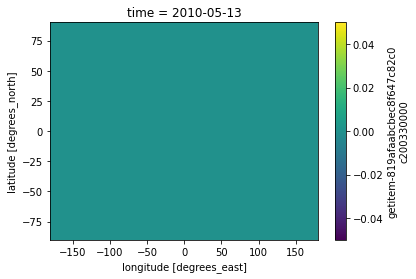

In [13]:
tmax_anomaly.sel(time='20100513').plot()

clim.nc  thresh.nc
